In [3]:
#This Jupyter notebook generates the data for machine leanning testing for one-day ahead prediction of currency moves.
#Trading signals based on momentum, RSI and PCA fair-value reversion are estimated

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Select currency pairs
currencies = ['CNY=X', 'THB=X', 'EUR=X', 'MYR=X', 'ILS=X', 
             'JPY=X', 'KRW=X', 'SGD=X', 'INR=X', 'PHP=X']

# Download data from Yahoo Finance, using close price
data = yf.download(currencies, start='2004-01-01', end=datetime.now())
df = data['Close'].reset_index()
column_mapping = {'Date': 'Date'}
for curr in currencies:
   column_mapping[curr] = curr
df = df.rename(columns=column_mapping)

# Final dataframe
data = df[['Date'] + currencies]

#Re-name col headings, clean data (fill forward) and create returns and volatility meansures
data = df[['Date', 'CNY=X', 'THB=X','EUR=X','MYR=X','ILS=X','JPY=X','KRW=X','SGD=X','INR=X','PHP=X']].copy()
data.columns = ['Date', 'CNY', 'THB','EUR','MYR','ILS','JPY','KRW','SGD','INR','PHP']
currencies = ['CNY', 'THB', 'EUR', 'MYR', 'ILS', 'JPY', 'KRW', 'SGD', 'INR', 'PHP']   
data = data.dropna(how='all')
data = data.ffill()
print(data)
# Create returns dataframe
returns_data = pd.DataFrame()
returns_data['Date'] = data['Date']
for currency in currencies:
   returns_data[f'{currency}_returns'] = data[currency].pct_change()

# Calculate 3-month (approximately 63 trading days) rolling standard deviation
rolling_std_data = pd.DataFrame()
rolling_std_data['Date'] = data['Date']

for currency in currencies:
   rolling_std_data[f'{currency}_rolling_3m_std'] = returns_data[f'{currency}_returns'].rolling(window=63).std()

C:\Users\Mike\AppData\Local\Temp\ipykernel_22596\2086933482.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(currencies, start='2004-01-01', end=datetime.now())
[*********************100%***********************]  10 of 10 completed


           Date       CNY        THB      EUR     MYR      ILS         JPY  \
0    2004-01-01       NaN  39.240002  0.79479  3.8147  4.37910  107.300003   
1    2004-01-02  8.266900  39.535000  0.79479  3.8019  4.39680  106.910004   
2    2004-01-05  8.267000  39.256001  0.78821  3.7972  4.37100  106.239998   
3    2004-01-06  8.267100  39.032001  0.78610  3.7950  4.37150  106.230003   
4    2004-01-07  8.267201  38.970001  0.79108  3.8052  4.39320  106.180000   
...         ...       ...        ...      ...     ...      ...         ...   
5626 2025-07-31  7.176400  32.709999  0.87494  4.2425  3.37537  149.225998   
5627 2025-08-01  7.200200  32.740002  0.87537  4.2625  3.39088  150.772003   
5628 2025-08-04  7.211600  32.369999  0.86306  4.2750  3.41308  147.343002   
5629 2025-08-05  7.178000  32.310001  0.86325  4.2335  3.41222  146.792999   
5630 2025-08-06  7.188600  32.340000  0.86380  4.2280  3.45040  146.792999   

              KRW      SGD        INR        PHP  
0     1181.5

In [18]:
#Estimate Moving Average X-over strategies
#Provides trading signals (+1,-1, 0) and backtested returns


def add_moving_averages(data, short_window=10, long_window=30):
    for col in currency_cols:
        data.loc[:, f'{col}_MA_short'] = data[col].rolling(window=short_window).mean()
        data.loc[:, f'{col}_MA_long'] = data[col].rolling(window=long_window).mean()
    return data

def generate_signals(data, currency):
    short_ma = f'{currency}_MA_short'
    long_ma = f'{currency}_MA_long'
    
    # 1 = Buy, -1 = Sell
    data.loc[:, f'{currency}_signal'] = np.where(data[short_ma] > data[long_ma], 1, -1)
    return data

def backtest_strategy(data, currency):
    data.loc[:, f'{currency}_trading_returns'] = 0.0
    for i in range(31, len(data)):
        data.loc[i, f'{currency}_trading_returns'] = (
            data.loc[i, currency] / data.loc[i-1, currency] - 1
        ) * data.loc[i-1, f'{currency}_signal']
    return data

def total_returns(data, currency):
    data.loc[:, f'{currency}_total_returns_momentum'] = 1.0
    for i in range(31, len(data)):
        data.loc[i, f'{currency}_total_returns_momentum'] = (
            data.loc[i-1, f'{currency}_total_returns_momentum'] * 
            (1 + data.loc[i, f'{currency}_trading_returns'])
        )
    return data

# Run backtest
data_ST_trend_strategy = data.copy()
data_ST_trend_strategy = add_moving_averages(data_ST_trend_strategy, short_window=10, long_window=30)
for col in currencies:
    data_ST_trend_strategy = generate_signals(data_ST_trend_strategy, currency=col)
    data_ST_trend_strategy = backtest_strategy(data_ST_trend_strategy, currency=col)
    data_ST_trend_strategy = total_returns(data_ST_trend_strategy, currency=col)
    
data_LT_trend_strategy = data.copy()
data_LT_trend_strategy = add_moving_averages(data_LT_trend_strategy, short_window=50, long_window=200)
for col in currencies:
    data_LT_trend_strategy = generate_signals(data_LT_trend_strategy, currency=col)
    data_LT_trend_strategy = backtest_strategy(data_LT_trend_strategy, currency=col)
    data_LT_trend_strategy = total_returns(data_LT_trend_strategy, currency=col)

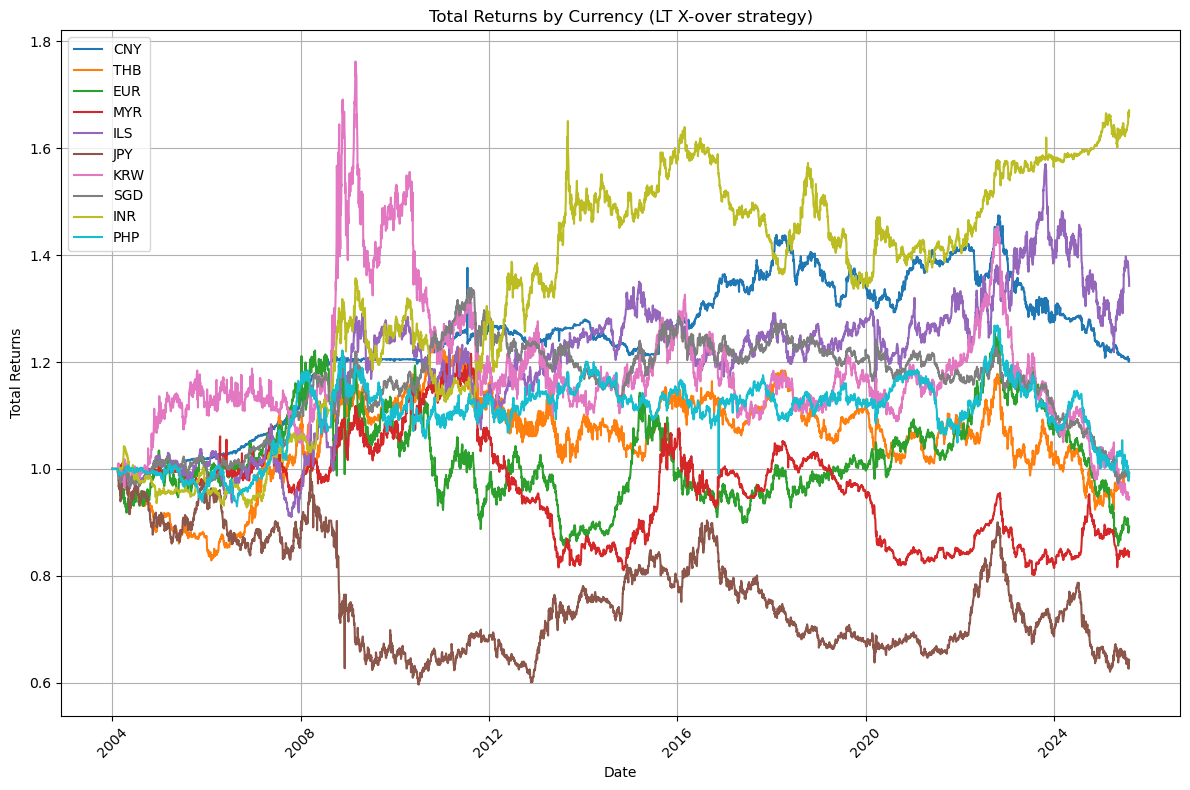

In [32]:
#Plot the total returns of the X-over MA trading strategy

plt.figure(figsize=(12, 8))

for currency in currencies:
   plt.plot(data_LT_trend_strategy['Date'], data_LT_trend_strategy[f'{currency}_total_returns_momentum'], label=currency)

plt.title('Total Returns by Currency (LT X-over strategy)')
plt.xlabel('Date')
plt.ylabel('Total Returns')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

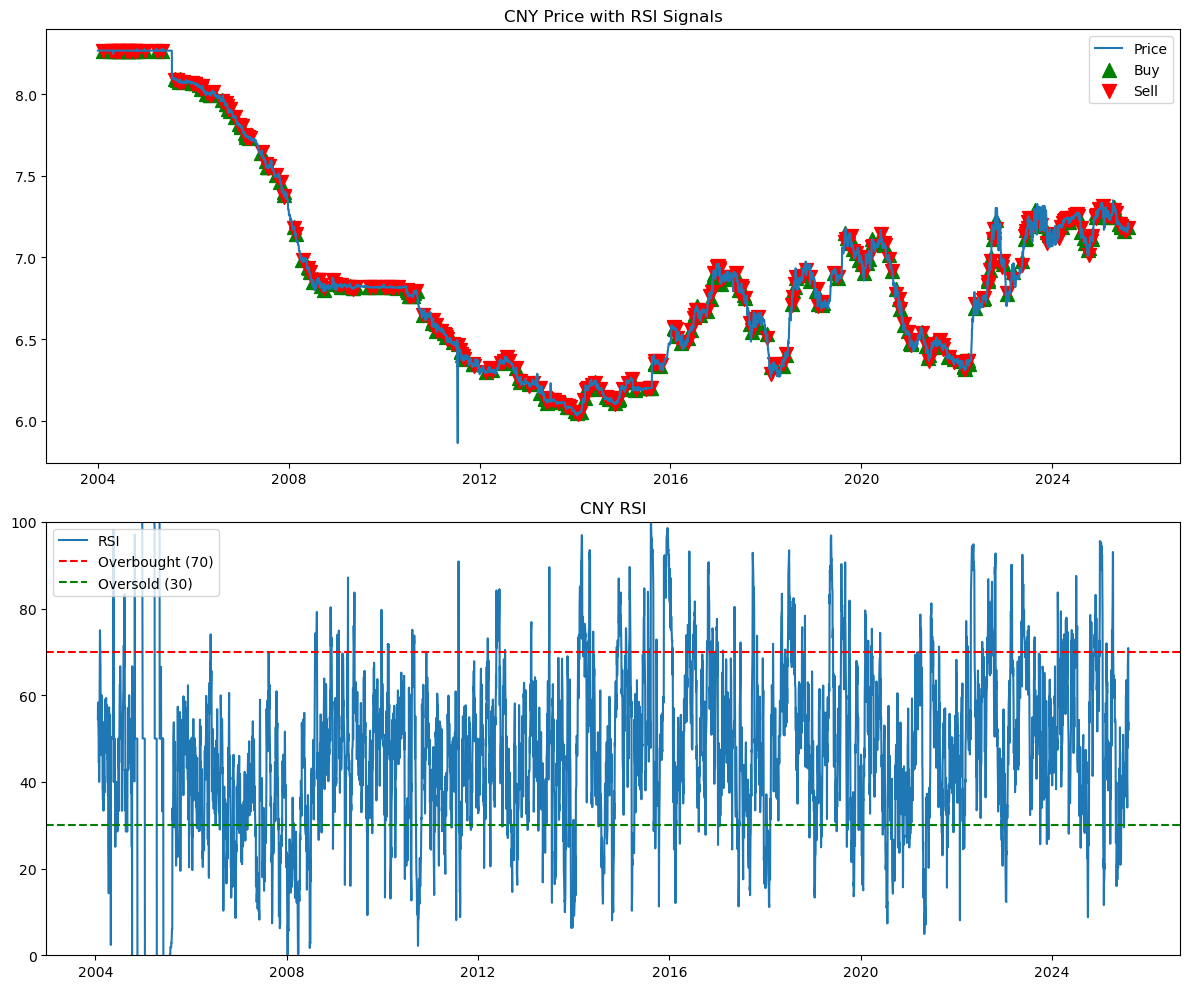

CNY RSI Strategy Total Return: -13.43%
THB RSI Strategy Total Return: -25.98%
EUR RSI Strategy Total Return: -25.37%
MYR RSI Strategy Total Return: -18.41%
ILS RSI Strategy Total Return: 6.03%
JPY RSI Strategy Total Return: 8.83%
KRW RSI Strategy Total Return: -50.01%
SGD RSI Strategy Total Return: -7.56%
INR RSI Strategy Total Return: -20.68%
PHP RSI Strategy Total Return: -33.99%


In [34]:
#RSI trading strategy
#Calulate trading signals (+1,-1,0) based on Relative Strength Indicator (RSI)


def calculate_rsi(data, currency, period=14):
    """Calculate RSI for a given currency"""
    price_col = currency
    
    # Calculate price changes
    delta = data[price_col].diff()
    
    # Separate gains and losses
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)
    
    # Calculate average gains and losses
    avg_gains = gains.rolling(window=period).mean()
    avg_losses = losses.rolling(window=period).mean()
    
    # Calculate RSI
    rs = avg_gains / avg_losses
    rsi = 100 - (100 / (1 + rs))
    
    data.loc[:, f'{currency}_RSI'] = rsi
    return data

def generate_rsi_signals(data, currency, oversold=30, overbought=70):
    """Generate trading signals based on RSI"""
    rsi_col = f'{currency}_RSI'
    
    # Buy when RSI crosses above oversold level
    data.loc[:, f'{currency}_rsi_signal'] = np.where(
        (data[rsi_col] > oversold) & (data[rsi_col].shift(1) <= oversold), 1,
        np.where(
            (data[rsi_col] < overbought) & (data[rsi_col].shift(1) >= overbought), -1, 0
        )
    )
    
    # Generate positions (entry/exit points)
    data.loc[:, f'{currency}_rsi_positions'] = data[f'{currency}_rsi_signal'].diff()
    
    return data

def backtest_rsi_strategy(data, currency):
    """Backtest RSI strategy"""
    # Create trading returns column
    data.loc[:, f'{currency}_rsi_returns'] = 0.0
    
    # Calculate returns based on signals
    for i in range(31, len(data)):  # Start after RSI calculation period
        price_return = data.loc[i, currency] / data.loc[i-1, currency] - 1
        signal = data.loc[i-1, f'{currency}_rsi_signal']
        data.loc[i, f'{currency}_rsi_returns'] = price_return * signal
    
    # Calculate cumulative returns
    data.loc[:, f'{currency}_rsi_total_returns'] = (1 + data[f'{currency}_rsi_returns']).cumprod()
    
    return data

# Apply RSI strategy to all currencies
for currency in currencies:
    data = calculate_rsi(data, currency, period=14)
    data = generate_rsi_signals(data, currency, oversold=30, overbought=70)
    data = backtest_rsi_strategy(data, currency)

# Plot RSI and signals for one currency
import matplotlib.pyplot as plt

def plot_rsi_strategy(data, currency):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Price and signals
    ax1.plot(data['Date'], data[currency], label='Price')
    buy_signals = data[data[f'{currency}_rsi_positions'] == 1]
    sell_signals = data[data[f'{currency}_rsi_positions'] == -1]
    
    ax1.scatter(buy_signals['Date'], buy_signals[currency], color='green', marker='^', s=100, label='Buy')
    ax1.scatter(sell_signals['Date'], sell_signals[currency], color='red', marker='v', s=100, label='Sell')
    ax1.set_title(f'{currency} Price with RSI Signals')
    ax1.legend()
    
    # RSI
    ax2.plot(data['Date'], data[f'{currency}_RSI'], label='RSI')
    ax2.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
    ax2.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
    ax2.set_title(f'{currency} RSI')
    ax2.set_ylim(0, 100)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Example: Plot RSI strategy for CNY
plot_rsi_strategy(data, 'CNY')

# Print performance summary
for currency in currencies:
    final_return = data.loc[data.index[-1], f'{currency}_rsi_total_returns']
    print(f'{currency} RSI Strategy Total Return: {(final_return-1)*100:.2f}%')


C:\Users\Mike\AppData\Local\Temp\ipykernel_22596\1967965279.py:86: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals[currency].iloc[i] = 0
C:\Users\Mike\AppData\Local\Temp\ipykernel_22596\1967965279.py:83: FutureWarning: ChainedAssignmen

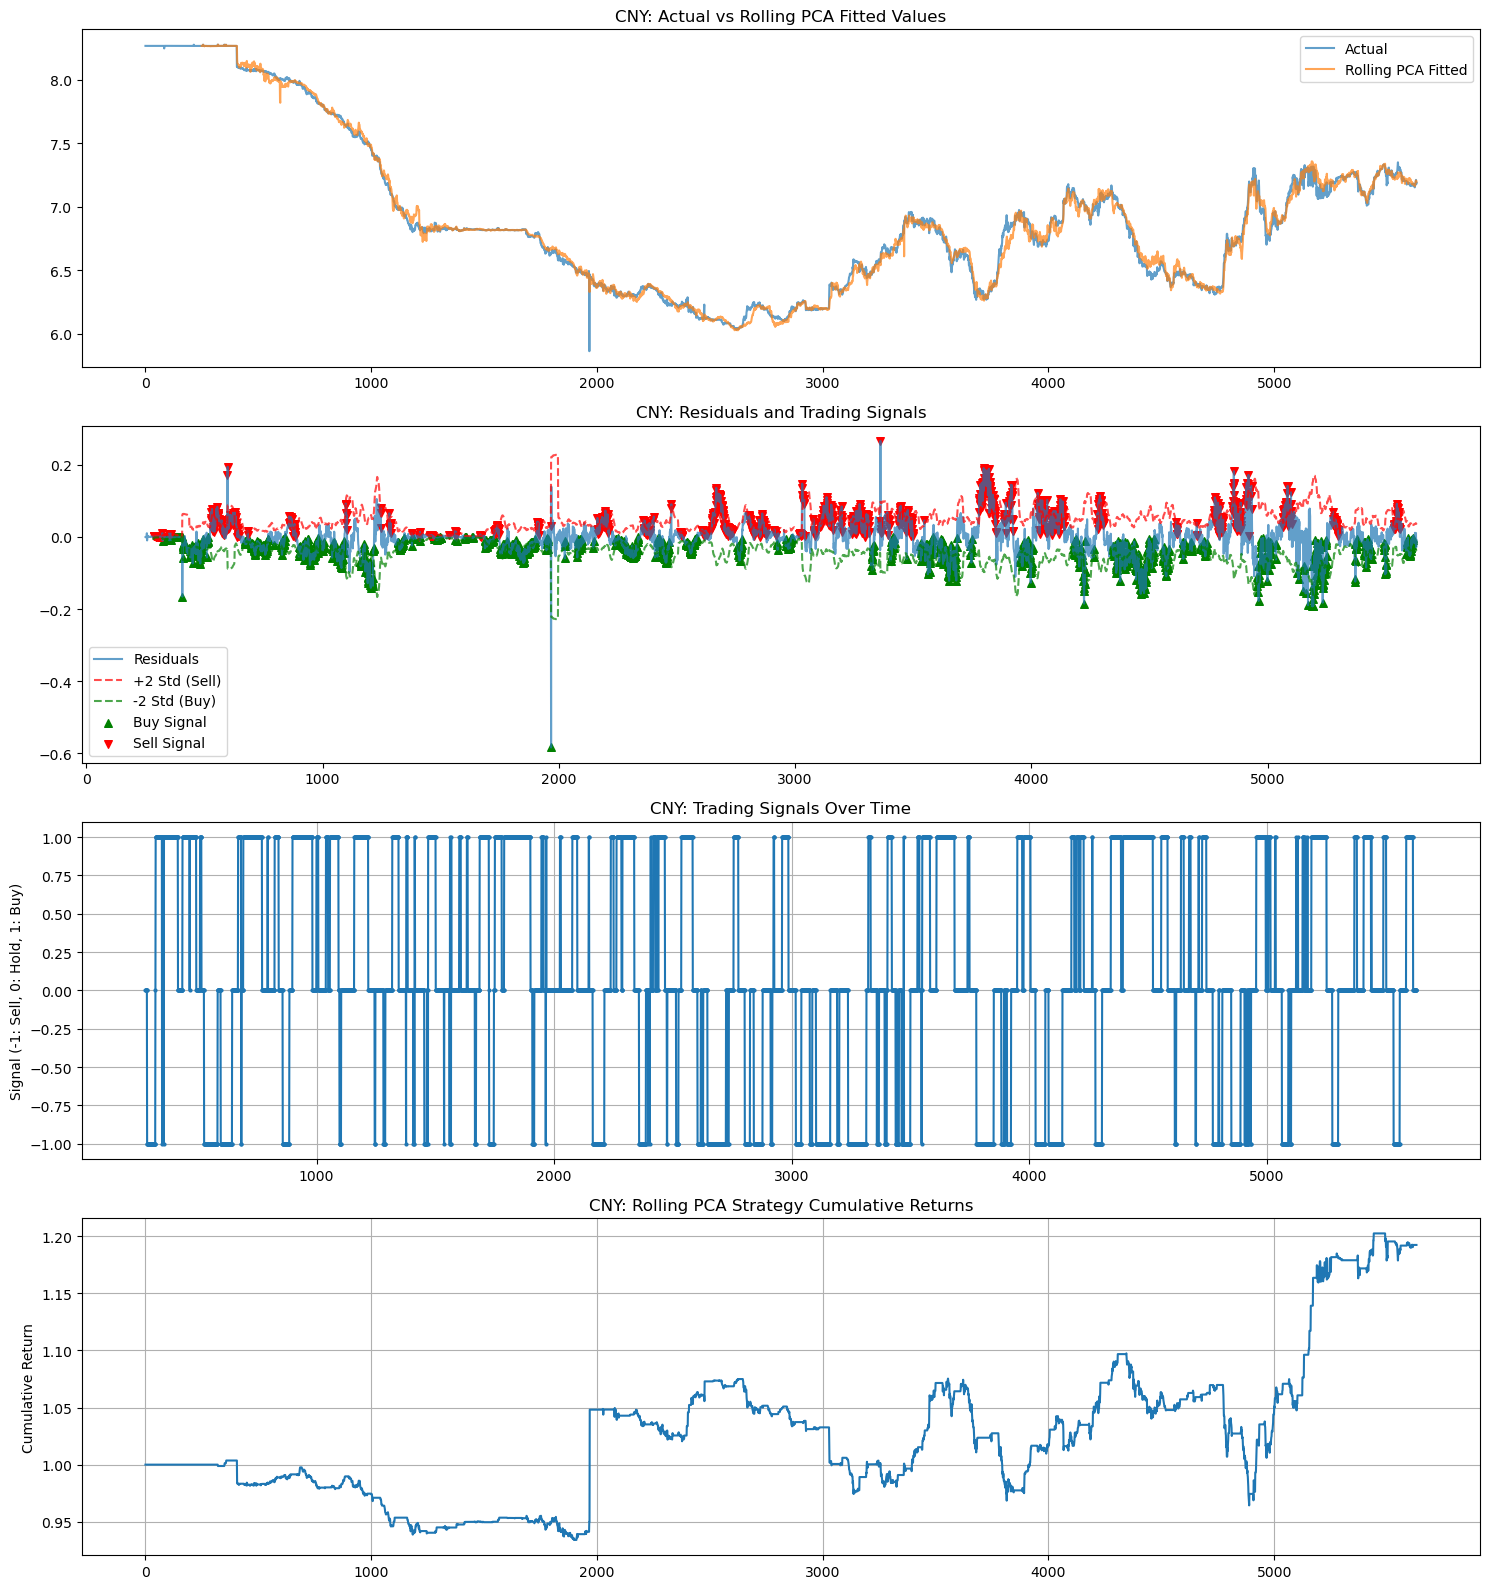

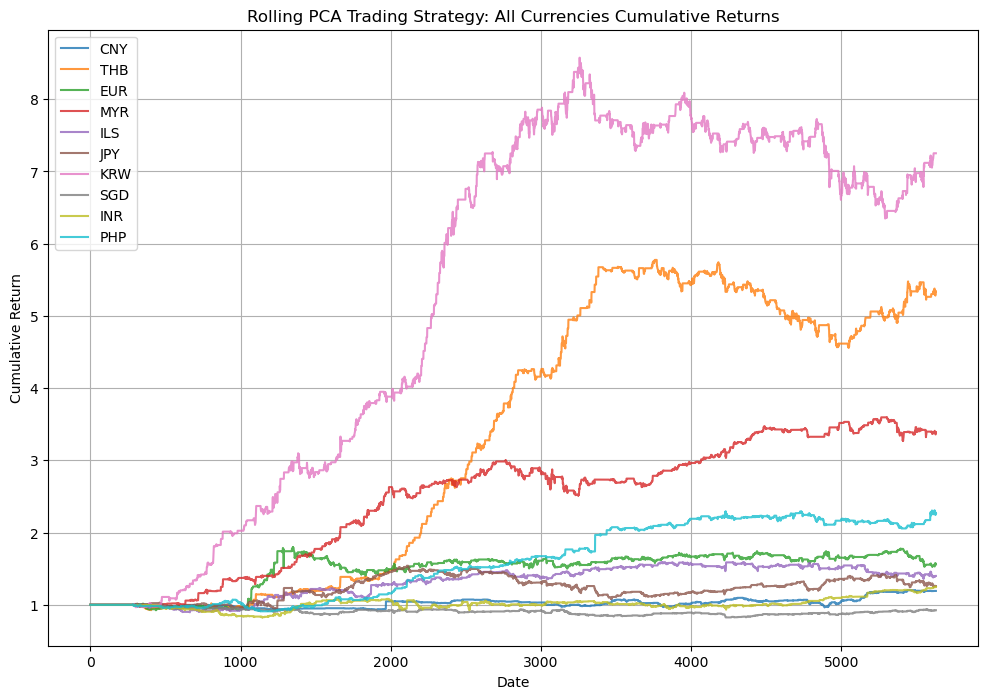

In [35]:
#PCA trading strategy
# Create trading signals from a PCA-derived calculation of fair value, based on PC1, PC2 and PC3 of the currency universe

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def rolling_pca_trading_strategy(data, window=250):
      
   # Prepare currency data
   currency_data = data[currencies].copy()
   
   # Initialize DataFrames
   fitted_values = pd.DataFrame(index=currency_data.index, columns=currencies)
   residuals = pd.DataFrame(index=currency_data.index, columns=currencies)
   signals = pd.DataFrame(index=currency_data.index, columns=currencies)
   returns = pd.DataFrame(index=currency_data.index, columns=currencies)
   
   # Rolling PCA calculation
   for i in range(window, len(currency_data)):
       window_data = currency_data.iloc[i-window:i].dropna()
       
       if len(window_data) < window * 0.8:  # Skip if too much missing data
           continue
           
       try:
           # Standardize the window data
           scaler = StandardScaler()
           scaled_window = scaler.fit_transform(window_data)
           
           # Perform PCA on the window
           pca = PCA(n_components=3)
           pca.fit(scaled_window)
           
           # Get current observation (last row of window)
           current_obs = window_data.iloc[-1:]#.values
           current_scaled = scaler.transform(current_obs)
           
           # Calculate fitted value
           pca_transformed = pca.transform(current_scaled)
           fitted_scaled = pca.inverse_transform(pca_transformed)
           fitted_original = scaler.inverse_transform(fitted_scaled)          
           fitted_values.iloc[i] = fitted_original[0]
           
           # Calculate residuals (actual - fitted)
           actual_values = currency_data.iloc[i]#.values
           residuals.iloc[i] = actual_values - fitted_original[0]
           
       except Exception as e:
           print(f"Error at index {i}: {e}")
           continue
   
   # Calculate rolling standard deviation of residuals (30-day window)
   residual_std = residuals.rolling(window=30).std()
   
   # Generate trading signals based on current residuals vs fitted values
   for currency in currencies:
       current_position = 0  
       for i in range(window + 30, len(currency_data)):
       
           current_actual = currency_data[currency].iloc[i]
           current_fitted = fitted_values[currency].iloc[i]
           current_std = residual_std[currency].iloc[i]
           
           if pd.notna(current_fitted) and pd.notna(current_std) and current_std > 0:
               residual = current_actual - current_fitted
               if current_position != 0:
                    if current_position == 1 and residual >= 0:
                        current_position = 0
                        signals[currency].iloc[i]
                    elif current_position == -1 and residual <= 0:
                        current_position = 0
                        signals[currency].iloc[i]
                    else:
                        signals[currency].iloc[i] = current_position
               
               # Buy when 2+ std devs below fitted (undervalued)
               if current_position == 0:
                   if residual < -2 * current_std:
                       signals[currency].iloc[i] = 1
                       current_position = 1 
               # Sell when 2+ std devs above fitted (overvalued)  
                   elif residual > 2 * current_std:
                       signals[currency].iloc[i] = -1
                       current_position = -1 
                   else:
                       signals[currency].iloc[i] = 0
                       current_position = 0 
   
   # Backtest the strategy
   for currency in currencies:
       daily_returns = currency_data[currency].pct_change()
       
       # Apply signals with 1-day lag
       strategy_returns = daily_returns * signals[currency].shift(1)
       returns[currency] = strategy_returns
   
   # Calculate cumulative returns
   cumulative_returns = (1 + returns.fillna(0)).cumprod()
   
   return {
       'currency_data': currency_data,
       'fitted_values': fitted_values,
       'residuals': residuals,
       'residual_std': residual_std,
       'signals': signals,
       'returns': returns,
       'cumulative_returns': cumulative_returns
   }

rolling_pca_results = rolling_pca_trading_strategy(data, window=250)
for currency in currencies:
   final_return = rolling_pca_results['cumulative_returns'][currency].iloc[-1]
  
# Plot results
def plot_rolling_pca_strategy(currency, results):
   fig, axes = plt.subplots(4, 1, figsize=(15, 16))
   
   # Plot 1: Actual vs Fitted values
   mask = pd.notna(results['fitted_values'][currency])
   axes[0].plot(results['currency_data'].index, 
               results['currency_data'][currency], 
               label='Actual', alpha=0.7)
   axes[0].plot(results['fitted_values'].index[mask], 
               results['fitted_values'][currency][mask], 
               label='Rolling PCA Fitted', alpha=0.7)
   axes[0].set_title(f'{currency}: Actual vs Rolling PCA Fitted Values')
   axes[0].legend()
   
   # Plot 2: Residuals with trading bands
   residuals = results['residuals'][currency]
   std_bands = results['residual_std'][currency]
   
   axes[1].plot(residuals.index, residuals, label='Residuals', alpha=0.7)
   axes[1].plot(residuals.index, 2*std_bands, 'r--', label='+2 Std (Sell)', alpha=0.7)
   axes[1].plot(residuals.index, -2*std_bands, 'g--', label='-2 Std (Buy)', alpha=0.7)
   
   # Mark trading signals
   buy_signals = results['signals'][currency] == 1
   sell_signals = results['signals'][currency] == -1
   
   if buy_signals.any():
       axes[1].scatter(residuals[buy_signals].index, residuals[buy_signals], 
                      color='green', marker='^', s=30, label='Buy Signal')
   if sell_signals.any():
       axes[1].scatter(residuals[sell_signals].index, residuals[sell_signals], 
                      color='red', marker='v', s=30, label='Sell Signal')
   
   axes[1].set_title(f'{currency}: Residuals and Trading Signals')
   axes[1].legend()
   
   # Plot 3: Trading signals over time
   axes[2].plot(results['signals'].index, results['signals'][currency], 
               label='Signal', marker='o', markersize=2)
   axes[2].set_title(f'{currency}: Trading Signals Over Time')
   axes[2].set_ylabel('Signal (-1: Sell, 0: Hold, 1: Buy)')
   axes[2].grid(True)
   
   # Plot 4: Cumulative returns
   axes[3].plot(results['cumulative_returns'].index, 
               results['cumulative_returns'][currency])
   axes[3].set_title(f'{currency}: Rolling PCA Strategy Cumulative Returns')
   axes[3].set_ylabel('Cumulative Return')
   axes[3].grid(True)
   
   plt.tight_layout()
   plt.show()

# Example: Plot for CNY
plot_rolling_pca_strategy('CNY', rolling_pca_results)

# Plot all currency cumulative returns
plt.figure(figsize=(12, 8))
for currency in currencies:
   returns_series = rolling_pca_results['cumulative_returns'][currency]
   if returns_series.notna().any():
       plt.plot(returns_series.index, returns_series, label=currency, alpha=0.8)

plt.title('Rolling PCA Trading Strategy: All Currencies Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


In [36]:

returns_PCA = pd.DataFrame()
returns_PCA=rolling_pca_results['returns']
returns_PCA.to_csv('returns_PCA_0.csv', index=False)


In [37]:
#Compile results to save as csv

#Signals
signal_LT_momentum = pd.DataFrame()
signal_ST_momentum = pd.DataFrame()
signal_RSI = pd.DataFrame()
signal_PCA = pd.DataFrame()
for currency in currency_cols:
    signal_LT_momentum[f'{currency}']=data_LT_trend_strategy[f'{currency}_signal']
    signal_ST_momentum[f'{currency}']=data_ST_trend_strategy[f'{currency}_signal']
    signal_RSI[f'{currency}']=data[f'{currency}_rsi_signal']
signal_PCA=rolling_pca_results['signals']

#Returns
returns_LT_momentum = pd.DataFrame()
returns_ST_momentum = pd.DataFrame()
returns_RSI = pd.DataFrame()
returns_PCA = pd.DataFrame()
for currency in currency_cols:
    returns_LT_momentum[f'{currency}']=data_LT_trend_strategy[f'{currency}_trading_returns']
    returns_ST_momentum[f'{currency}']=data_ST_trend_strategy[f'{currency}_trading_returns']
    returns_RSI[f'{currency}']=data[f'{currency}_rsi_returns']
returns_PCA=rolling_pca_results['returns']

#Export
signal_LT_momentum.to_csv('signal_LT_momentum.csv', index=False)
signal_ST_momentum.to_csv('signal_ST_momentum.csv', index=False)
signal_RSI.to_csv('signal_RSI.csv', index=False)
signal_PCA.to_csv('signal_PCA.csv', index=False)
returns_LT_momentum.to_csv('returns_LT_momentum.csv', index=False)
returns_ST_momentum.to_csv('returns_ST_momentum.csv', index=False)
returns_RSI.to_csv('returns_RSI.csv', index=False)
returns_PCA.to_csv('returns_PCA.csv', index=False)
data.to_csv('data_add.csv', index=False)
rolling_std_data.to_csv('rolling_std_data.csv', index=False)
